In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve

### Load the data

In [3]:
df = pd.read_excel('../../data_set/monthlyInvestigation/cleaned_monthly_investigations.xlsx')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Subject_ID                399 non-null    object        
 1   Month                     399 non-null    datetime64[ns]
 2   Albumin (g/L)             399 non-null    float64       
 3   BU - post HD              399 non-null    float64       
 4   BU - pre HD               399 non-null    float64       
 5   Hb (g/dL)                 399 non-null    float64       
 6   S Ca (mmol/L)             399 non-null    float64       
 7   SCR- post HD (µmol/L)     399 non-null    float64       
 8   SCR- pre HD (µmol/L)      399 non-null    float64       
 9   Serum K Post-HD (mmol/L)  399 non-null    float64       
 10  Serum K Pre-HD (mmol/L)   399 non-null    float64       
 11  Serum Na Pre-HD (mmol/L)  399 non-null    float64       
 12  UA (mg/dL)            

### Compute Urea Reduction Rate (URR)

In [5]:
df['URR'] = ((df['BU - pre HD'] - df['BU - post HD']) / df['BU - pre HD']) * 100
df['URR'] = df['URR'].round(3)

In [6]:
print(df[['BU - pre HD', 'BU - post HD', 'URR']].head())

   BU - pre HD  BU - post HD     URR
0        13.50          0.26  98.074
1        14.14          0.38  97.313
2        12.30          5.85  52.439
3        18.90          6.30  66.667
4        14.79          6.75  54.361


### Create the Target

In [7]:
df['target'] = (df['URR'] < 65).astype(int)

In [8]:
print(df[['BU - pre HD', 'BU - post HD', 'URR', 'target']].head())

   BU - pre HD  BU - post HD     URR  target
0        13.50          0.26  98.074       0
1        14.14          0.38  97.313       0
2        12.30          5.85  52.439       1
3        18.90          6.30  66.667       0
4        14.79          6.75  54.361       1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Subject_ID                399 non-null    object        
 1   Month                     399 non-null    datetime64[ns]
 2   Albumin (g/L)             399 non-null    float64       
 3   BU - post HD              399 non-null    float64       
 4   BU - pre HD               399 non-null    float64       
 5   Hb (g/dL)                 399 non-null    float64       
 6   S Ca (mmol/L)             399 non-null    float64       
 7   SCR- post HD (µmol/L)     399 non-null    float64       
 8   SCR- pre HD (µmol/L)      399 non-null    float64       
 9   Serum K Post-HD (mmol/L)  399 non-null    float64       
 10  Serum K Pre-HD (mmol/L)   399 non-null    float64       
 11  Serum Na Pre-HD (mmol/L)  399 non-null    float64       
 12  UA (mg/dL)            

### Define x and y

In [10]:
unique_ids = df['Subject_ID'].unique()

train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

train_df = df[df['Subject_ID'].isin(train_ids)]
test_df = df[df['Subject_ID'].isin(test_ids)]

#### Checks for any overlapping Subject_IDs between train and test data.

In [11]:
def check_patient_overlap(train_df, test_df):
    train_ids = set(train_df['Subject_ID'])
    test_ids = set(test_df['Subject_ID'])
    overlapping_ids = train_ids.intersection(test_ids)
    
    if overlapping_ids:
        print("⚠️ Overlapping Subject_IDs found:")
        print(overlapping_ids)
        return True
    else:
        print("✅ No overlapping Subject_IDs.")
        return False

check_patient_overlap(train_df, test_df)

✅ No overlapping Subject_IDs.


False

In [12]:
train_df

,Subject_ID,Month,Albumin (g/L),BU - post HD,BU - pre HD,Hb (g/dL),S Ca (mmol/L),SCR- post HD (µmol/L),SCR- pre HD (µmol/L),Serum K Post-HD (mmol/L),Serum K Pre-HD (mmol/L),Serum Na Pre-HD (mmol/L),UA (mg/dL),URR,target
0,RHD_THP_001,2024-01-01,28.6,0.26,13.50,11.0,2.25,96.91,538.00,2.40,4.30,136.0,392.0,98.074,0
1,RHD_THP_001,2024-02-01,37.7,0.38,14.14,13.1,2.23,97.37,513.60,2.90,4.32,136.0,408.0,97.313,0
2,RHD_THP_001,2024-03-01,40.6,5.85,12.30,12.8,2.24,276.00,560.00,3.90,4.75,141.4,404.0,52.439,1
3,RHD_THP_001,2024-04-01,35.8,6.30,18.90,12.2,1.97,325.40,689.00,4.40,4.20,138.4,487.0,66.667,0
4,RHD_THP_001,2024-05-01,36.9,6.75,14.79,12.9,2.53,374.80,601.93,4.90,3.80,138.2,336.0,54.361,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,RHD_THP_045,2024-08-01,31.4,3.70,8.29,9.6,2.30,162.00,402.50,3.13,3.78,134.6,365.0,55.368,1
395,RHD_THP_045,2024-09-01,32.6,0.27,11.37,10.5,2.54,63.80,466.00,2.36,4.20,134.0,345.0,97.625,0
396,RHD_THP_045,2024-10-01,32.6,0.27,8.50,11.3,2.54,63.80,397.00,2.36,4.20,134.0,345.0,96.824,0
397,RHD_THP_045,2024-11-01,32.1,0.27,15.60,11.0,2.49,128.90,440.00,2.36,4.05,134.0,352.0,98.269,0


In [13]:
X_train = train_df.drop( columns=["Subject_ID", "Month", "URR", "target"] )
y_train = train_df["target"]

X_test = test_df.drop( columns=["Subject_ID", "Month", "URR", "target"] )
y_test = test_df["target"]

In [14]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (322, 11) (322,)
Test set shape: (77, 11) (77,)


# Train the ML Model

- 322 training samples
- 11 features
- Binary classification task (URR < 65 as target)

## Random Forest

In [15]:
modelRandomForest = RandomForestClassifier(random_state=42)
modelRandomForest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## XGBoost

In [16]:
modelXGBoost = XGBClassifier(random_state=42)
modelXGBoost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

## Support Vector Machine (SVM)

In [17]:
modelSVM = SVC(probability=True)
modelSVM.fit(X_train, y_train)

SVC(probability=True)

## Logistic Regression

In [29]:
modelLogisticRegression = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
    random_state=42,
    solver='liblinear',
    penalty='l2',
    n_jobs=-1,
    verbose=0,
    )
modelLogisticRegression.fit(X_train, y_train)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42,
                   solver='liblinear')

## LightGBM

In [30]:
modelLightGBM = LGBMClassifier(random_state=42)
modelLightGBM.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 89, number of negative: 233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 848
[LightGBM] [Info] Number of data points in the train set: 322, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.276398 -> initscore=-0.962402
[LightGBM] [Info] Start training from score -0.962402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMClassifier(random_state=42)

# Evaluate the Models

In [31]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(8,6))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X_test)[:,1]
        elif hasattr(model, "decision_function"):
            y_probs = model.decision_function(X_test)
        else:
            print(f"Skipping ROC for {name} (no probability or decision function).")
            continue
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_precision_recall_curve(models, X_test, y_test):
    plt.figure(figsize=(8,6))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X_test)[:,1]
        elif hasattr(model, "decision_function"):
            y_probs = model.decision_function(X_test)
        else:
            print(f"Skipping PR curve for {name} (no probability or decision function).")
            continue
        precision, recall, _ = precision_recall_curve(y_test, y_probs)
        plt.plot(recall, precision, label=name)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

def plot_feature_importance(model, X_train, model_name):
    if hasattr(model, 'feature_importances_'):
        fi = model.feature_importances_
        indices = fi.argsort()[::-1]
        features = X_train.columns

        plt.figure(figsize=(10,6))
        sns.barplot(x=fi[indices], y=features[indices])
        plt.title(f'Feature Importance for {model_name}')
        plt.show()
    else:
        print(f"No feature importance available for {model_name}.")

In [32]:
models = {
    'Random Forest': modelRandomForest,
    'XGBoost': modelXGBoost,
    'LightGBM': modelLightGBM,
    'Logistic Regression': modelLogisticRegression,
    'SVM': modelSVM
}

Model: Random Forest


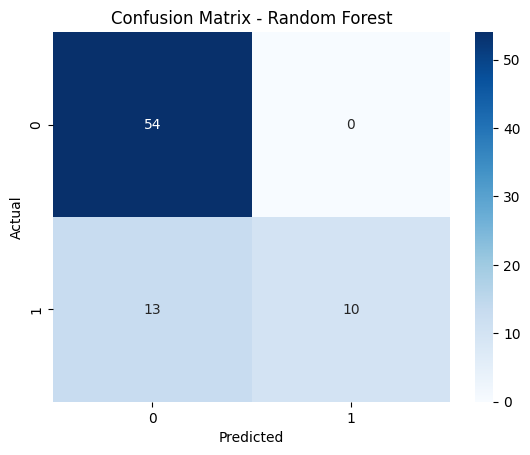

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        54
           1       1.00      0.43      0.61        23

    accuracy                           0.83        77
   macro avg       0.90      0.72      0.75        77
weighted avg       0.86      0.83      0.81        77

------------------------------------------------------------
Model: XGBoost


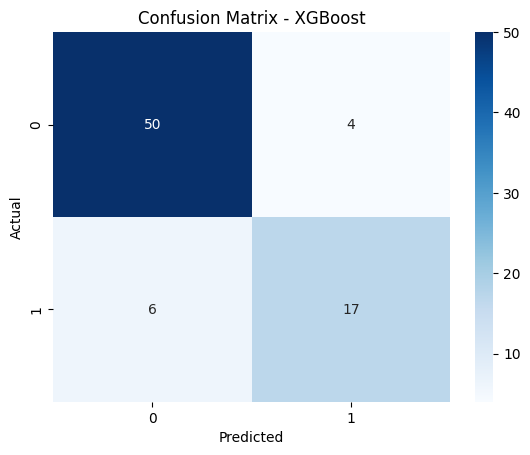

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        54
           1       0.81      0.74      0.77        23

    accuracy                           0.87        77
   macro avg       0.85      0.83      0.84        77
weighted avg       0.87      0.87      0.87        77

------------------------------------------------------------
Model: LightGBM


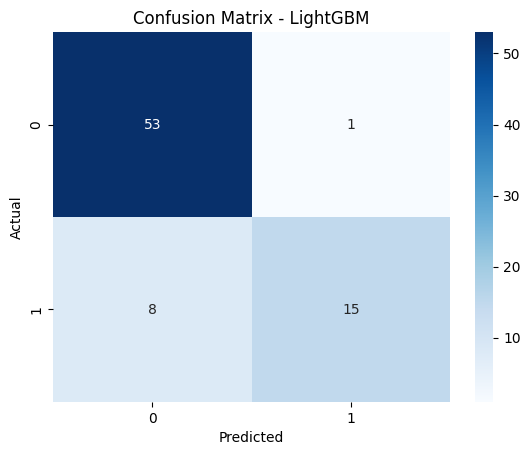

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        54
           1       0.94      0.65      0.77        23

    accuracy                           0.88        77
   macro avg       0.90      0.82      0.85        77
weighted avg       0.89      0.88      0.88        77

------------------------------------------------------------
Model: Logistic Regression


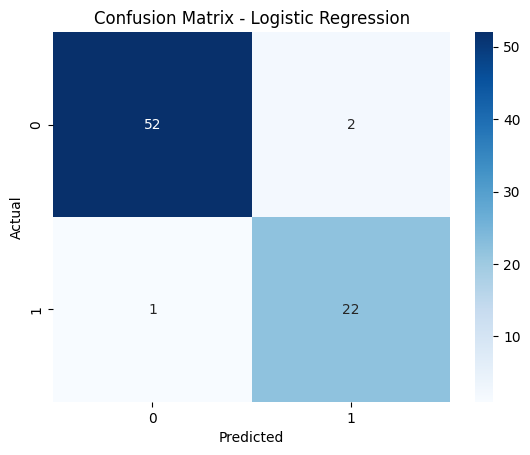

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        54
           1       0.92      0.96      0.94        23

    accuracy                           0.96        77
   macro avg       0.95      0.96      0.95        77
weighted avg       0.96      0.96      0.96        77

------------------------------------------------------------
Model: SVM


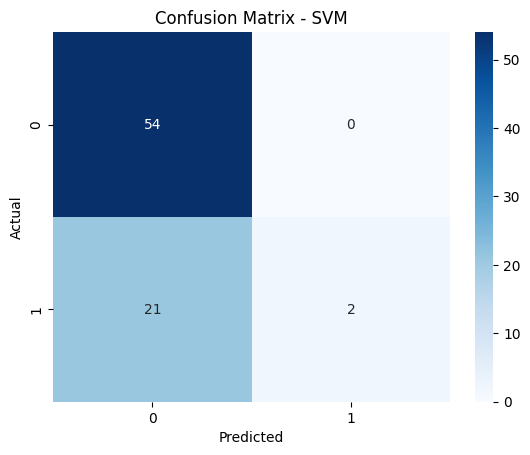

Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        54
           1       1.00      0.09      0.16        23

    accuracy                           0.73        77
   macro avg       0.86      0.54      0.50        77
weighted avg       0.80      0.73      0.63        77

------------------------------------------------------------


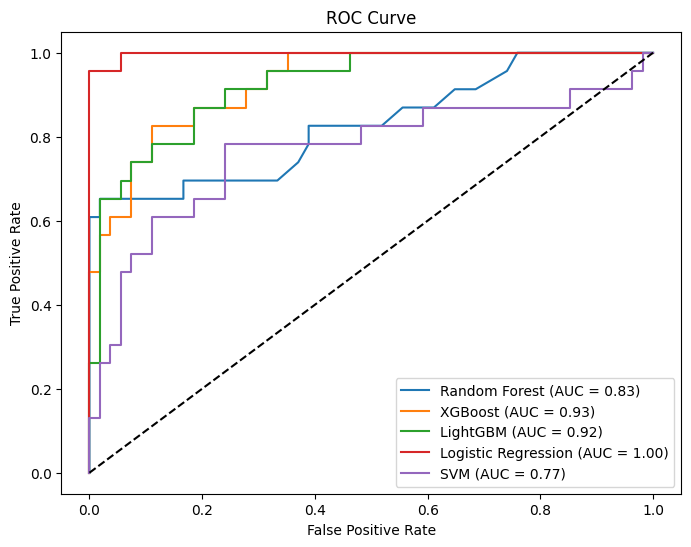

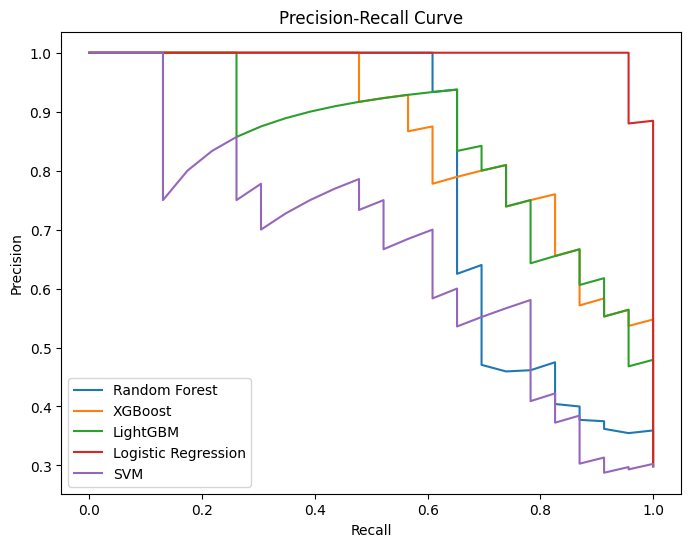

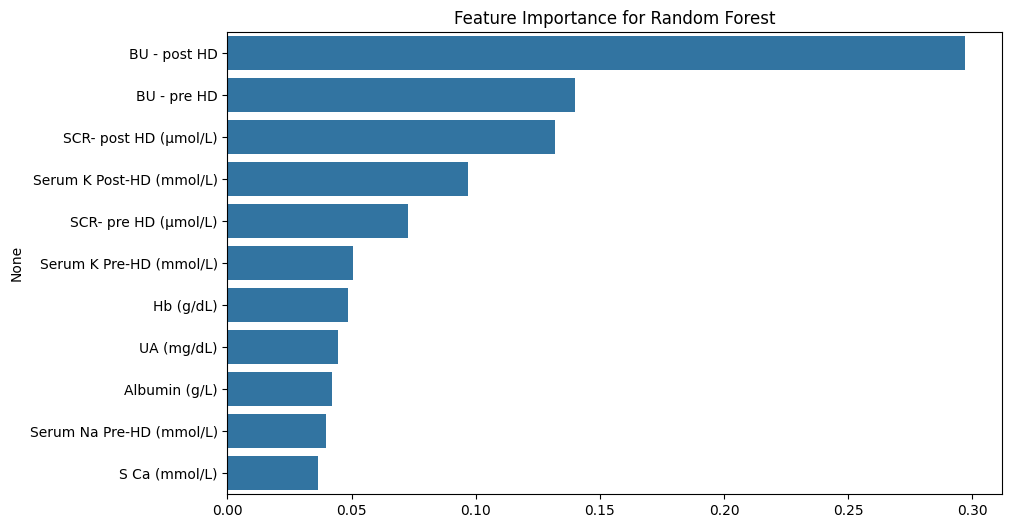

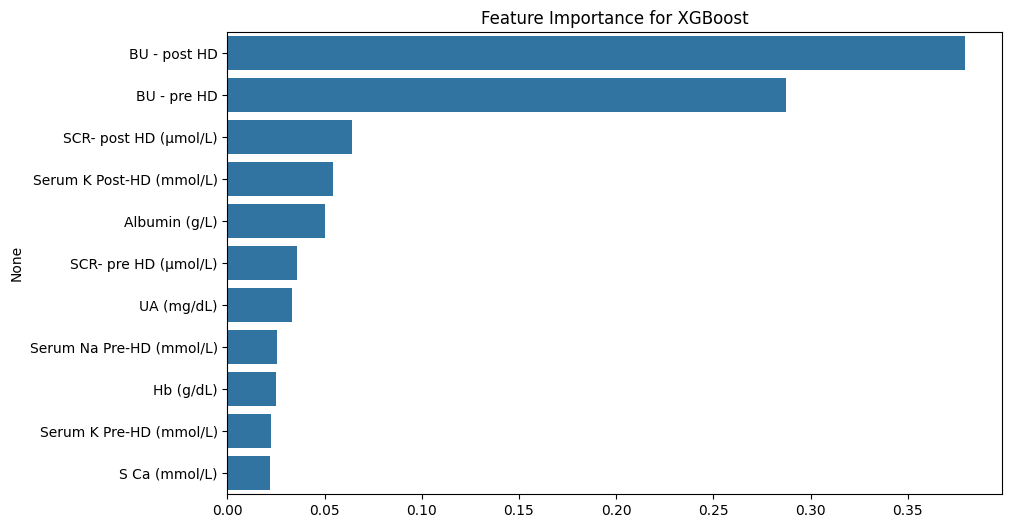

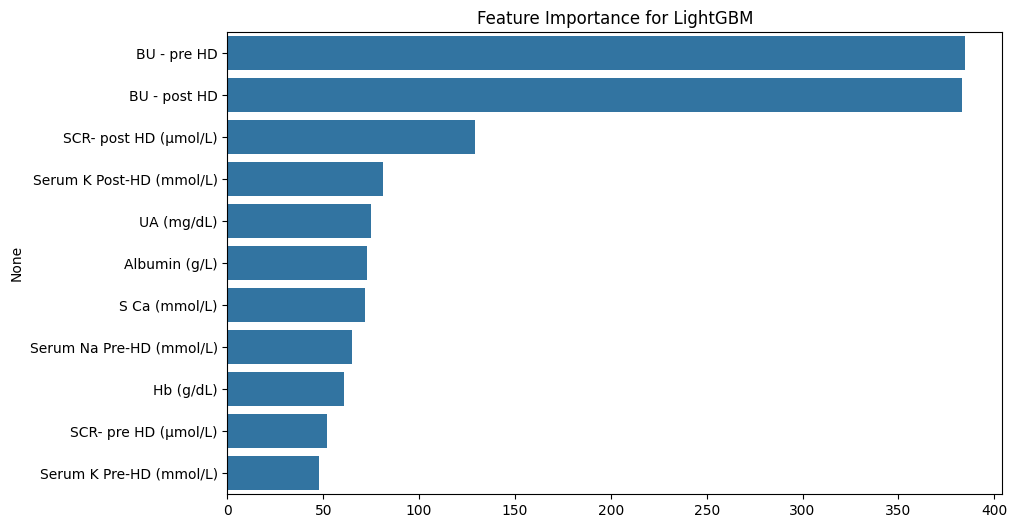

No feature importance available for Logistic Regression.
No feature importance available for SVM.


In [33]:
from sklearn.metrics import classification_report

# Plot confusion matrices
for name, model in models.items():
    print(f"Model: {name}")
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, f'Confusion Matrix - {name}')

    # Print classification reports# Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)
    
# Plot ROC curves
plot_roc_curve(models, X_test, y_test)

# Plot Precision-Recall curves
plot_precision_recall_curve(models, X_test, y_test)

# Plot feature importance for tree-based models
for name, model in models.items():
    plot_feature_importance(model, X_train, name)